# PIPELINE

In [1]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.base import TransformerMixin

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from time import time
import pandas as pd
import numpy as np
import warnings
import pickle
import re

% matplotlib inline
# nltk.download_gui()
warnings.filterwarnings('ignore')

## LOAD TRAINING DATA

In [2]:
df = pd.read_csv('data/train.tsv',sep='\t')
keep = set(['Product Long Description','Product Name','tag'])
drop = set(df.columns) - keep
df.drop(drop,axis=1,inplace=True)

old_indx = [5674,7689,10559]
for indx in old_indx:
    df.loc[indx,'tag'] = '[1229823]'
# 5674 [1229821, 1229823, 1229818] 
# 7689 [1229817, 1229823, 1229821] 
# 10559 [1229821, 1229823, 1180168, 1229818]

## keep samples w/ ONLY single tag 
drop_indices = []
pattern = r'1229823'
for index,tag in enumerate(df.tag):
    temp = tag.split(',')
    if len(temp)>1:
        drop_indices.append(index)
df.drop(df.index[drop_indices],inplace=True)

# drop samples w/ NaN values
df.dropna(inplace=True)
df.head(5)

,Product Long Description,Product Name,tag
0,<b>Interfaces/Ports</b><li>Network (RJ-45): ...,Cyberpower Metered ATS PDU 200-240V 20A 1U 10-...,[4483]
1,General InformationThe SmartMount&reg; Univers...,Peerless SmartMount SF650P Universal Flat Wall...,[581514]
2,"Control Transformer, VA Rating 50VA, Input Vol...","DAYTON 31EH66 Control Transformer Fused,4.02H ...",[4483]
3,<b>General Information</b><li>Product Type: ...,STEREN-CUSTOM INSTALL 255-047 STEREN MINI TO R...,[4537]
5,Features- Transformer Ground Connectors are us...,Morris 91902 Transformer Ground Connector,[4537]


## Double Check number of tags and their respective amount

In [3]:
print '# tags:{}'.format(len(df.tag.value_counts()))
print df.tag.value_counts()

# tags:32
[4537]       2667
[4483]       2002
[581514]      730
[529295]      513
[95987]       401
[106546]      388
[447913]      379
[4538]        244
[127175]      241
[4536]        220
[1229821]     201
[650659]      189
[1180168]     175
[522484]      169
[1229817]     154
[1070524]     146
[5065]         80
[1071165]      49
[1225174]      47
[1085065]      47
[1229820]      23
[62056]        22
[1084835]      21
[3304195]      21
[4457]         19
[1229819]      18
[1229825]      13
[648819]        6
[1229818]       4
[133270]        3
[645319]        3
[1229823]       3
Name: tag, dtype: int64


## TRANSFORMERS

In [4]:
class HtmlTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        cleaner = re.compile(r'<.*?>')
        return pd.Series(X.apply(lambda x: re.sub(cleaner,' ',x)))
    def fit(self, X, y=None, **fit_params):
        return self
    
class RemoveCamelCaseTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return pd.Series(X.apply(lambda x: re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ',x)))
    def fit(self, X, y=None, **fit_params):
        return self

class RemoveSymsTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return pd.Series(X.apply(lambda x: re.sub(re.compile(r'[^A-za-z0-9\s\.]'),' ',x)))
    def fit(self, X, y=None, **fit_params):
        return self

class TokenizeTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return pd.Series(X.apply(lambda x:word_tokenize(x)))
    def fit(self, X, y=None, **fit_params):
        return self

# class GetSerialCodesTransformer(TransformerMixin):
#     def transform(self, X, **transform_params):
#         return pd.Series(X.apply(lambda x: re.findall(r'[A-Z]+[A-Z0-9]+[A-Za-z0-9]*[^A-za-z0-9\s]*[A-Z0-9]+',x)))        
#     def fit(self, X, y=None, **fit_params):
#         return self

class LemmatizeTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        lmtzr = WordNetLemmatizer()
        return pd.Series(X.apply(lambda x:[lmtzr.lemmatize(token.lower()) for token in x]))
    def fit(self, X, y=None, **fit_params):
        return self

class RemoveStopWordsTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        stop = set(stopwords.words('english'))
        return pd.Series(X.apply(lambda x: ' '.join([token for token in x if token not in stop])))
    def fit(self, X, y=None, **fit_params):
        return self

## View SVD's explained variance ratio over n_components

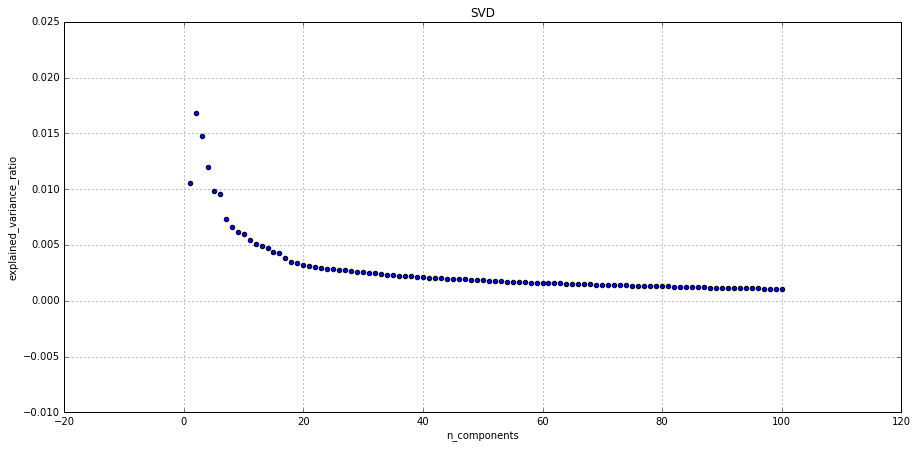

In [5]:
X = df['Product Long Description']
t1 = HtmlTransformer().fit_transform(X)
t2 = RemoveCamelCaseTransformer().fit_transform(t1)
t3 = RemoveSymsTransformer().fit_transform(t2)
t4 = TokenizeTransformer().fit_transform(t3)
t5 = LemmatizeTransformer().fit_transform(t4)
t6 = RemoveStopWordsTransformer().fit_transform(t5)
t7 = TfidfVectorizer().fit_transform(t6)
SVD = TruncatedSVD(100)
t8 = SVD.fit_transform(t7)
plt.figure(figsize=(15,7))
plt.scatter(x=range(1,101),y=SVD.explained_variance_ratio_)
plt.title('SVD')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio')
plt.grid(True)    
plt.show()

## Check to see if all tags are in train(90%) and test(10%) set

In [6]:
for i in range(1,100):
    X = df['Product Long Description']
    y = df['tag']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=i)
    if len(y_train.unique()) == len(y_test.unique()):
        print 'Choose this random state: {}'.format(i)
        print 'total unique tags ==> {}'.format(len(y.unique()))
        print '(train) unique tags ==> {}'.format(len(y_train.unique()))
        print '(test) unique tags ==> {}'.format(len(y_test.unique()))

Choose this random state: 59
total unique tags ==> 32
(train) unique tags ==> 32
(test) unique tags ==> 32


## MACHINE LEARNING ALGORITHMS

Naive Bayes and Random Forest did substantially worse than XG Boost. Therefore, I opted to use only XG Boost and tune the parameters (depth, learning rate, and number of trees) for an optimal score.

In [7]:
models = {}
# models['Naive_Bayes'] = GaussianNB()
# models['Random_Forest'] = RandomForestClassifier(random_state=42)
models['XG_Boost'] = XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.05) 

## TRAIN MODELS

Here I trained two models. Both using Gradient Boosting Classifier (XG Boost) algorithm, but trained on "product name" and "product long description", respectively. 

In [9]:
start = time()
labels = ['Product Name','Product Long Description']
for label in labels:
    X = df[label]
    y = df['tag']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=59)
    if len(y_train.unique())!=32 and len(y_test.unique())!=32:
        print '###########################################################'        
        print '############### NOT BALANCED!!! NOOOOOO!!! ################'
        print '###########################################################'        
        print 'LABEL:{} \t num_train_tags:{} \t num_test_tags:{}'.format(label,
                                                                         len(y_train.unique()),
                                                                         len(y_test.unique())) 
    for name,model in models.items(): 
        PIPELINE = make_pipeline(HtmlTransformer(),
                                 RemoveCamelCaseTransformer(),
                                 RemoveSymsTransformer(),
                                 TokenizeTransformer(),
                                 LemmatizeTransformer(),
                                 RemoveStopWordsTransformer(),
                                 TfidfVectorizer(),
                                 TruncatedSVD(100),
                                model)
        results = PIPELINE.fit(X_train,y_train)
        y_pred  = results.predict(X_test)
        report  = classification_report(y_test,y_pred)
        con_mat = confusion_matrix(y_test,y_pred)
        acc_sc  = accuracy_score(y_test,y_pred)
        f1_sc   = f1_score(y_test,y_pred)
        with open('models/MODEL_{}_{}.plk'.format(name,label),'wb') as f:
            pickle.dump(results,f)
        print '#################################################################################'
        print '#################################################################################'
        print 'MODEL: {} \t TIME: {} \t LABEL: {}'.format(name,time()-start,label)
        print 
        print report
        print 
        print con_mat 
        print
        print 'ACCURACY SCORE: {}'.format(acc_sc)
        print 
        print 'F1 SCORE: {}'.format(f1_sc)
        print 

#################################################################################
#################################################################################
MODEL: XG_Boost 	 TIME: 731.497154951 	 LABEL: Product Name

             precision    recall  f1-score   support

   [106546]       0.79      0.61      0.69        36
  [1070524]       0.20      0.22      0.21         9
  [1071165]       1.00      0.29      0.44         7
  [1084835]       0.50      0.25      0.33         4
  [1085065]       0.50      1.00      0.67         1
  [1180168]       0.93      0.88      0.90        16
  [1225174]       1.00      0.40      0.57         5
  [1229817]       0.56      0.75      0.64        12
  [1229818]       1.00      0.50      0.67         2
  [1229819]       0.00      0.00      0.00         5
  [1229820]       1.00      1.00      1.00         2
  [1229821]       0.69      1.00      0.82        20
  [1229823]       0.00      0.00      0.00         1
  [1229825]       0.00      0.00

In [ ]:
# models = {}
# models['Product Name']  = XGB_MODEL_PN
# models['Product Long Description'] = XGB_MODEL_PLD

# with open('models/MODEL_XG_Boost_Product_Long_Description.plk','rb') as f:
#     XGB_MODEL_PLD = pickle.load(f)
    
# with open('models/MODEL_XG_Boost_Product_Name.plk','rb') as f:
#     XGB_MODEL_PN = pickle.load(f)
# fig,axs = plt.subplots(nrows=len(models),ncols=2)
# fig.set_figwidth(15)
# fig.set_figheight(10)                       
# for name,model in models.items():
#     if name == 'Product_Name':
#         X_test = X1
#         y_test = 
#     y_pred = model.predict(X_test)
#     y_pred_probs = results.predict_proba(X_test)
#     score = accuracy_score(y_test,y_pred)
    
#     precision,recall,threshold_PR = precision_recall_curve(y_test,y_pred_probs[:,1],pos_label=1)
#     fpr,tpr,threshold_ROC = roc_curve(y_test,y_pred_probs[:,1],pos_label=1)
#     AUC = auc(fpr,tpr)
    
#     print '############################## MODEL:{} ##############################'.format(name)
#     print 'AUC: {}'.format(AUC)
#     report = classification_report(y_test,y_pred)
#     con_mat = confusion_matrix(y_test,y_pred)
#     i+=1
#     ax = axs[-1+i,0]
#     ax.plot(recall,precision)
#     ax.set_title('Precision-Recall')
#     ax.set_xlabel('Recall')
#     ax.set_ylabel('Precision')
#     ax.grid(True)
#     ax = axs[-1+i,1]
#     ax.plot(fpr,tpr)
#     ax.set_title('ROC Curve')
#     ax.set_xlabel('False Positive Rate')
#     ax.set_ylabel('True Positive Rate')
#     ax.grid(True)